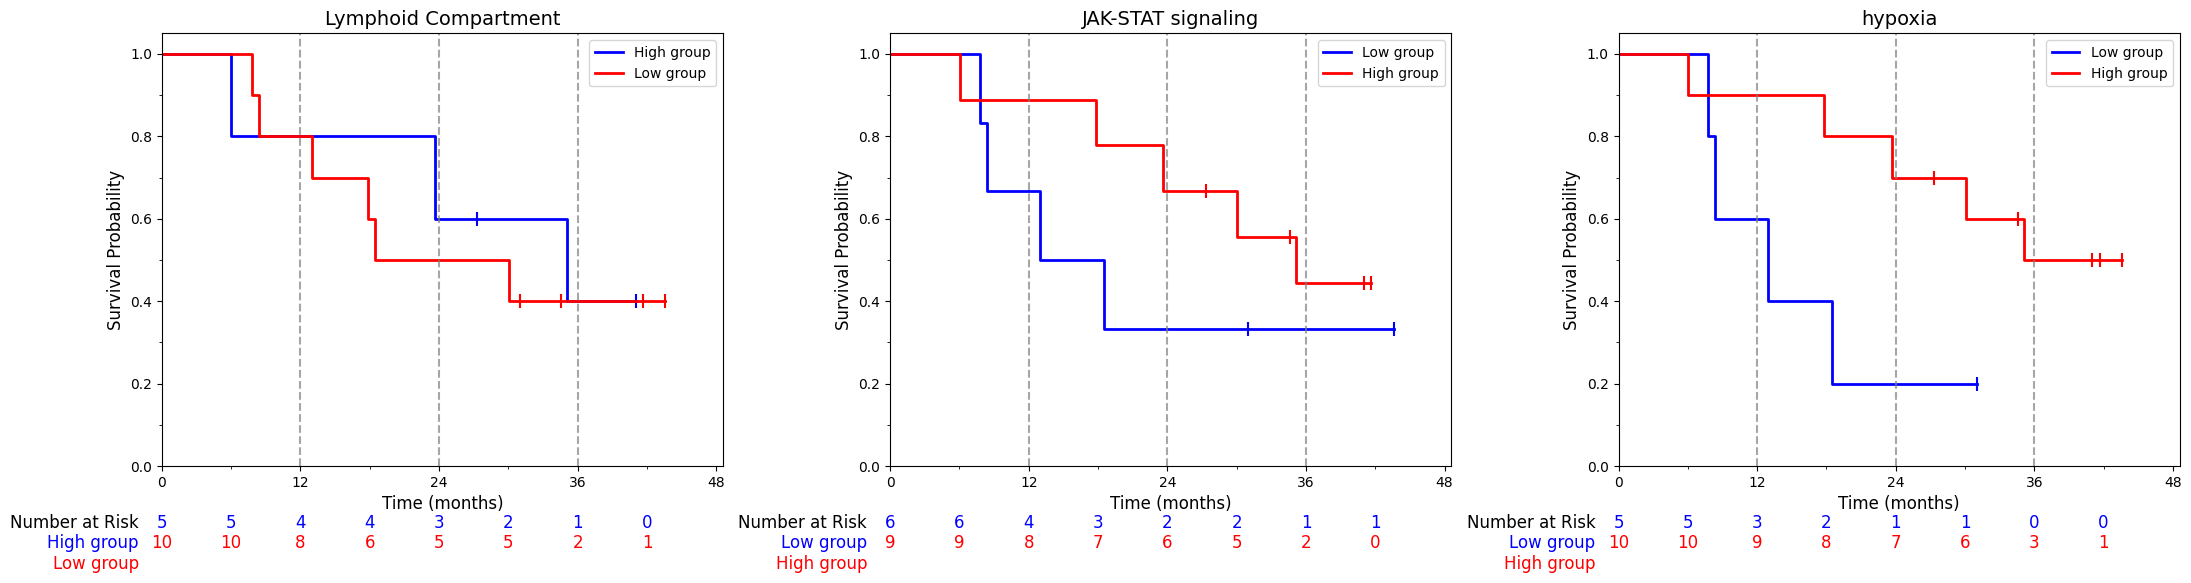

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ファイルのパス
file_path = "/Users/rshibaki/Library/CloudStorage/GoogleDrive-ryota.shibaki@gmail.com/マイドライブ/ADJUST試験/DATA/dataset_250129.xlsx"

# Excelからデータ読み込み
df = pd.read_excel(file_path, sheet_name="dataset", engine="openpyxl")

# カプランマイヤー曲線の作成に必要なデータを取得
columns_needed = ["DFSMONTHS", "DFS_event", "Lymphoid Compartment", "JAK-STAT signaling", "hypoxia"]
df_selected = df[columns_needed].dropna()

# カテゴリごとのグループ名のマッピング
group_labels = {
    "Lymphoid Compartment": {0: "High group", 1: "Low group"},
    "JAK-STAT signaling": {0: "Low group", 1: "High group"},
    "hypoxia": {0: "Low group", 1: "High group"}
}

# カテゴリごとのKMプロット作成関数
def plot_km_by_category(ax, category_name):
    unique_groups = sorted(df_selected[category_name].dropna().unique())
    colors = ["blue", "red"]  # 色分け (0: 青, 1: 赤)

    risk_times = [0, 6, 12, 18, 24, 30, 36, 42]
    risk_counts_by_group = {group: [] for group in unique_groups}

    for i, group in enumerate(unique_groups):
        df_group = df_selected[df_selected[category_name] == group].copy()
        
        # データを時間順にソート
        df_group = df_group.sort_values("DFSMONTHS")
        
        # イベント発生数と生存確率を計算
        time = np.insert(df_group["DFSMONTHS"].values, 0, 0)  # 0ヶ月から開始
        event = df_group["DFS_event"].values
        
        n_at_risk = len(df_group)
        survival_prob = [1.0]
        for t, e in zip(time[1:], event):
            if e == 1:
                n_at_risk -= 1
            survival_prob.append(n_at_risk / len(df_group))

        # グループ名を変更してラベルに適用
        label_name = group_labels[category_name].get(group, f"{category_name} {group}")
        ax.step(time, survival_prob, where="post", label=label_name, linewidth=2, color=colors[i])

        # センサリング（打ち切りデータ）のプロット
        censor_times = df_group["DFSMONTHS"][df_group["DFS_event"] == 0]
        censor_probs = [survival_prob[np.where(time == t)[0][0]] for t in censor_times]
        ax.scatter(censor_times, censor_probs, marker="|", s=100, color=colors[i])

        # Number at Risk の計算
        risk_counts_by_group[group] = [df_group[df_group["DFSMONTHS"] >= t].shape[0] for t in risk_times]

    # 軸ラベルと範囲の設定
    ax.set_xlabel("Time (months)", fontsize=12)
    ax.set_ylabel("Survival Probability", fontsize=12)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, df_selected["DFSMONTHS"].max() + 5)

    # 軸の目盛り設定
    ax.set_xticks(np.arange(0, df_selected["DFSMONTHS"].max() + 12, 12))
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(plt.MultipleLocator(6))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))

    # 12, 24, 36ヶ月の補助線
    for x in [12, 24, 36]:
        ax.axvline(x=x, linestyle="--", color="gray", alpha=0.7)

    # 12, 24, 36ヶ月の生存割合の表示
    for x in [12, 24, 36]:
        if x in time:
            survival_prob_x = survival_prob[np.where(time == x)[0][0]]
            ax.text(x, survival_prob_x + 0.03, f"{survival_prob_x*100:.1f}%", fontsize=10, color="black", ha="right")

    ax.legend(fontsize=10)
    ax.set_title(f"{category_name}", fontsize=14)

    # Number at Risk の追加（色分け）
    for i, t in enumerate(risk_times):
        for j, group in enumerate(unique_groups):
            ax.text(t, -0.15 - (j * 0.05), f"{risk_counts_by_group[group][i]}", fontsize=12, color=colors[j], ha="center")

    ax.text(-2, -0.15, "Number at Risk", fontsize=12, ha="right", color="black")
    ax.text(-2, -0.20, group_labels[category_name][unique_groups[0]], fontsize=12, ha="right", color=colors[0])
    ax.text(-2, -0.25, group_labels[category_name][unique_groups[1]], fontsize=12, ha="right", color=colors[1])



# 保存フォルダの指定（ユーザー指定のフォルダに変更）
output_dir = "/Users/rshibaki/Documents/project/ADJUST/Figure"  # 必要に応じて変更してください

# 出力ファイル名
output_filename = "KaplanMeier_DFS_TR.png"
output_path = os.path.join(output_dir, output_filename)

# プロットの準備
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# それぞれのカテゴリーでKMプロットを作成
plot_km_by_category(axes[0], "Lymphoid Compartment")
plot_km_by_category(axes[1], "JAK-STAT signaling")
plot_km_by_category(axes[2], "hypoxia")

# レイアウト調整と保存
plt.tight_layout()
plt.savefig(output_path, dpi=300, bbox_inches="tight")

# 結果の保存を通知
output_path